## Dataset processing

In [1]:
#Software Defect Prediction 
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

#add dataset normalization and feature selection function

def data_preprocessor(datafilename_as_csv_inquotes):
    original_data = pd.read_csv(datafilename_as_csv_inquotes)
    original_data.isnull().values.any() #Gives false ie:No null value in dataset
    original_data = original_data.fillna(value=False)
    original_X = pd.DataFrame(original_data.drop(['defects'],axis=1))
    original_Y = original_data['defects']
    original_Y = pd.DataFrame(original_Y)


    x_train1, x_test, y_train1, y_test= train_test_split(original_X, original_Y, test_size = .1,
                                                              random_state=12)
    
    #now we resample, and from that we take training and validation sets
    
    sm = SMOTE(random_state=12, sampling_strategy = 1.0)
    x, y = sm.fit_resample(x_train1, y_train1)
    y_train2 = pd.DataFrame(y, columns=['defects'])
    x_train2 = pd.DataFrame(x, columns=original_X.columns)
    
    
    x_train, x_val, y_train, y_val= train_test_split(x_train2, y_train2, test_size = .1,
                                                              random_state=12)
    
    combined_training_data = x_train.copy()
    combined_training_data['defects'] = y_train
    
    
    
    import seaborn as sns
    corr = combined_training_data.corr()
    sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)
    
    
    
    return original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val 

## Model (CNN, SVM, Decision Tree, XGBoost, Naive Bayes, ANN)

In [24]:
import pandas as pd

def NN(original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val):   
    # Importing the Keras libraries and packages
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    
    # Initialising the ANN
    classifier = Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 15 , activation = 'relu', input_dim = len(original_X.columns)))
    # Adding the second hidden layer
    classifier.add(Dense(units = 8, activation = 'relu'))
    classifier.add(Dense(units = 5, activation = 'relu'))
    # Adding the output layer
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    # Compiling the ANN
    
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting the ANN to the Training set
    classifier.fit(x_train, y_train, batch_size = 10, epochs = 50)
    
    #Making the predictions and evaluating the model
    # Predicting the Test set results
    y_pred = classifier.predict(x_val)
    y_pred = (y_pred > 0.5)
    y_pred = pd.DataFrame(y_pred, columns=['defects'])
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_val, y_pred)
    from sklearn.metrics import accuracy_score
    accuracy_score(y_val, y_pred)
    
    return classifier

    
def random_forest(original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)
    clf.fit(x_train, y_train.values.ravel())
    return clf

def svm(original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val):
    from sklearn.svm import SVC
    clf = SVC(gamma='auto')
    clf.fit(x_train, y_train.values.ravel())
    return clf

def XGBoost(original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val):
    from xgboost import XGBClassifier
    clf = xgb = XGBClassifier(
    max_depth=9,
    learning_rate=0.01,
    n_estimators=500,
    reg_alpha=1.1,
    colsample_bytree = 0.9, 
    subsample = 0.9,
    n_jobs = 5
)
    clf.fit(x_train, y_train.values.ravel(), eval_set= [(x_val, y_val.values.ravel())], early_stopping_rounds=50)
    return clf
    

def cnn(original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val):
    from keras.models import Sequential
    from keras.layers import Dense,Dropout,Conv2D,Conv1D,Flatten,MaxPool2D
    #create model
    
    x_train_matrix = x_train.values
    x_val_matrix = x_val.values
    y_train_matrix = y_train.values
    y_val_matrix = y_val.values
    
    ytrainseries = y_train['defects']
    yvalseries = y_val['defects']

    img_rows, img_cols = 1,len(original_X.columns)
    
    x_train1 = x_train_matrix.reshape(x_train_matrix.shape[0], img_rows, img_cols, 1)
    x_val1 = x_val_matrix.reshape(x_val_matrix.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

    model = Sequential()
    #add model layers
    #conv layers
    model.add(Conv2D(64, kernel_size=1, activation='relu',input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=1, activation='relu'))
    model.add(Conv2D(16, kernel_size=1, activation='relu'))
    # desne layer
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #train the model
    model.fit(x_train1, y_train_matrix, epochs=50)    
    y_pred = model.predict(x_val1)>0.5
    y_pred_df = pd.DataFrame(y_pred)
    
    return model

## Evaluation

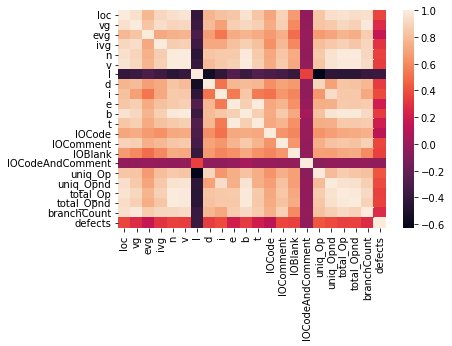

In [47]:
import pandas as pd

data = '/content/data/cm1.csv'
original_data , original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val = data_preprocessor(data)
all_data = [original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val]

In [41]:
from sklearn.metrics import *

def print_accuracy(model):
    if (model == nn_clf):
        y_pred_on_val = model.predict(x_val)>0.5
        y_pred_on_test = model.predict(x_test)>0.5

    elif (model == cnn_clf):
        x_val_matrix = x_val.values
        x_val1 = x_val_matrix.reshape(x_val_matrix.shape[0], 1, len(x_val.columns), 1)
        y_pred_on_val = model.predict(x_val1)>0.5
        x_test_matrix = x_test.values
        x_test1 = x_test_matrix.reshape(x_test_matrix.shape[0], 1, len(x_test.columns), 1)
        y_pred_on_test = model.predict(x_test1)>0.5
    else:
        y_pred_on_val = model.predict(x_val)
        y_pred_on_test = model.predict(x_test)
        
    print('******', str(model), '******')   
    print('<Validation Set>')
    print('Accuracy:',balanced_accuracy_score(y_val,y_pred_on_val))
    print('Avg Precision:', average_precision_score(y_val,y_pred_on_val))
    print('f1_score:', f1_score(y_val,y_pred_on_val,average='weighted',labels=np.unique(y_pred_on_val)))
    print('Precision:', precision_score(y_val,y_pred_on_val, labels=np.unique(y_pred_on_val)))
    print('Recall:', recall_score(y_val, y_pred_on_val,labels=np.unique(y_pred_on_val)))
    print('ROC_AUC:',roc_auc_score(y_val,y_pred_on_val))
    print("\n\n")
    # print('<Test Set>')
    # print('Accuracy:',balanced_accuracy_score(y_test,y_pred_on_test))
    # print('Avg Precision:', average_precision_score(y_test,y_pred_on_test))
    # print('f1_score:', f1_score(y_test,y_pred_on_test, average='weighted',labels=np.unique(y_pred_on_test)))
    # print('Precision:', precision_score(y_test,y_pred_on_test,zero_division=1))
    # print('Recall:', recall_score(y_test, y_pred_on_test))
    # print('ROC_AUC:',roc_auc_score(y_test,y_pred_on_test))
    y_pred_on_val_df = pd.DataFrame(y_pred_on_val, columns=['defects1'])
    y_pred_on_test_df = pd.DataFrame(y_pred_on_test, columns=['defects1'])
    val_result = pd.concat([y_val['defects'].reset_index(drop=True), y_pred_on_val_df['defects1']],axis=1)
    val_result = val_result.rename(columns={'defects':'val_actual', 'defects1':'val_predict'})
    test_result = pd.concat([y_test['defects'].reset_index(drop=True),y_pred_on_test_df['defects1']],axis=1)
    test_result = test_result.rename(columns={'defects':'test_actual','defects1':'test_predict'})
    return val_result, test_result

In [42]:
# model evaluation calculate and score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score,  mean_squared_error
# model evaluation 
from sklearn.metrics import classification_report, confusion_matrix

# metrics method
def metrics_calculate(model_name, y_val, y_pred):
    '''
    0. basic metrics values ['accuracy', 'precision', 'recall', 'fpr', 'fnr', 'auc']
    1. classification report
    2. confusion matrix
    '''
    y_val = np.reshape(y_val, -1).astype(np.int32)
    y_pred = np.where(np.reshape(y_pred, -1) > 0.5, 1, 0)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    fpr = fp / (tn + fp)
    fnr = fn / (tp + fn)
    auc = roc_auc_score(y_val, y_pred)
    # print('Model:%s Acc:%.8f Prec:%.8f Recall:%.8f FNR:%.8f FPR:%.8f AUC:%.8f' % (model_name, accuracy, precision, recall, fnr, fpr, auc))
    print(model_name, 'classification report:\n', classification_report(y_val, y_pred))
    print(model_name, 'confusion_matrix:\n', confusion_matrix(y_val, y_pred))
    print('\n%s FNR:%.8f FPR:%.8f\n%s accuracy:%.8f' % (model_name, fnr, fpr, model_name, accuracy_score(y_pred,y_val)))

In [43]:
def calculate_defect_identified(model,df_x, df_y):
  if (model == nn_clf):
    result = model.predict(df_x)>0.5
  
  elif(model == cnn_clf):
    df_matrix = df_x.values
    df_val1 = df_matrix.reshape(df_matrix.shape[0], 1, len(df_x.columns), 1)
    result = model.predict(df_val1)>0.5

  else:
    result = model.predict(df_x)
  

  actual = list(df_y["defects"])
  result = list(result)
  total_pos = df_y.value_counts()[1]
  count = 0
  
  for i in range(len(actual)):
    if(actual[i] == True):
      if(actual[i] == result[i]):
        count +=1


  return (count / total_pos )

In [48]:
full_dataset_x = pd.concat([x_train, x_val, x_test], axis=0)
full_dataset_y = pd.concat([y_train, y_val, y_test], axis=0)

data_name = "CM1"
print(f"Dataset name: {data_name}")
defect_cnt = full_dataset_y.value_counts()[1]
total = len(full_dataset_y)
density = defect_cnt / total
print(f"Defect count: {defect_cnt}")
print(f"Total count: {total}")
print(f"Density: {round(density*100, 2)}")

Dataset name: CM1
Defect count: 417
Total count: 866
Density: 48.15


#### ANN result

In [49]:
nn_clf = NN(*all_data)
nn_val_result, nn_test_result = print_accuracy(nn_clf)

Epoch 1/50
74/74 [==============================] - 1s 2ms/step - loss: 510.3506 - accuracy: 0.5123
Epoch 2/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.4959
Epoch 3/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6345 - accuracy: 0.4959
Epoch 4/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6224 - accuracy: 0.4959
Epoch 5/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6225 - accuracy: 0.5777
Epoch 6/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6169 - accuracy: 0.6240
Epoch 7/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6198 - accuracy: 0.6322
Epoch 8/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6144 - accuracy: 0.6281
Epoch 9/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6112 - accuracy: 0.6253
Epoch 10/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6128 - accuracy: 0.6226
Epoch 11/50
74/74

In [50]:
metrics_calculate('ANN', nn_val_result["val_actual"], nn_val_result["val_predict"])

ANN classification report:
               precision    recall  f1-score   support

           0       0.95      0.45      0.62        44
           1       0.61      0.97      0.75        38

    accuracy                           0.70        82
   macro avg       0.78      0.71      0.68        82
weighted avg       0.79      0.70      0.68        82

ANN confusion_matrix:
 [[20 24]
 [ 1 37]]

ANN FNR:0.02631579 FPR:0.54545455
ANN accuracy:0.69512195


In [51]:
calculate_defect_identified(nn_clf,full_dataset_x, full_dataset_y)

28/28 [==============================] - 0s 1ms/step


0.9400479616306955

#### CNN result

In [52]:
cnn_clf = cnn(*all_data)
cnn_val_result, cnn_test_result = print_accuracy(cnn_clf)

Epoch 1/50
23/23 [==============================] - 1s 3ms/step - loss: 638.4445 - accuracy: 0.4659
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 22.9780 - accuracy: 0.4687
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 15.6457 - accuracy: 0.4659
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 19.0725 - accuracy: 0.5245
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 18.5649 - accuracy: 0.5831
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 20.4906 - accuracy: 0.5831
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 13.4673 - accuracy: 0.6172
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 5.7394 - accuracy: 0.6253
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss: 8.0774 - accuracy: 0.6185
Epoch 10/50
23/23 [==============================] - 0s 3ms/step - loss: 13.9042 - accuracy: 0.6253
Epoch 11/5

In [53]:
metrics_calculate('CNN', cnn_val_result["val_actual"], cnn_val_result["val_predict"])

CNN classification report:
               precision    recall  f1-score   support

           0       0.69      0.77      0.73        44
           1       0.70      0.61      0.65        38

    accuracy                           0.70        82
   macro avg       0.70      0.69      0.69        82
weighted avg       0.70      0.70      0.69        82

CNN confusion_matrix:
 [[34 10]
 [15 23]]

CNN FNR:0.39473684 FPR:0.22727273
CNN accuracy:0.69512195


In [54]:
calculate_defect_identified(cnn_clf,full_dataset_x, full_dataset_y)

28/28 [==============================] - 0s 2ms/step


0.5155875299760192

#### XGBoost result

In [55]:
xgboost_clf = XGBoost(*all_data)
xgboost_val_result, xgboost_test_result = print_accuracy(xgboost_clf)

[0]	validation_0-error:0.170732
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.170732
[2]	validation_0-error:0.170732
[3]	validation_0-error:0.158537
[4]	validation_0-error:0.170732
[5]	validation_0-error:0.158537
[6]	validation_0-error:0.170732
[7]	validation_0-error:0.170732
[8]	validation_0-error:0.170732
[9]	validation_0-error:0.170732
[10]	validation_0-error:0.170732
[11]	validation_0-error:0.170732
[12]	validation_0-error:0.170732
[13]	validation_0-error:0.170732
[14]	validation_0-error:0.170732
[15]	validation_0-error:0.170732
[16]	validation_0-error:0.170732
[17]	validation_0-error:0.170732
[18]	validation_0-error:0.170732
[19]	validation_0-error:0.170732
[20]	validation_0-error:0.170732
[21]	validation_0-error:0.170732
[22]	validation_0-error:0.170732
[23]	validation_0-error:0.170732
[24]	validation_0-error:0.170732
[25]	validation_0-error:0.170732
[26]	validation_0-error:0.170732
[27]	validation_0-error:0.170732
[28]	validation_0-er

In [56]:
metrics_calculate('xgboost', xgboost_val_result["val_actual"], xgboost_val_result["val_predict"])

xgboost classification report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.84        44
           1       0.79      0.89      0.84        38

    accuracy                           0.84        82
   macro avg       0.84      0.85      0.84        82
weighted avg       0.85      0.84      0.84        82

xgboost confusion_matrix:
 [[35  9]
 [ 4 34]]

xgboost FNR:0.10526316 FPR:0.20454545
xgboost accuracy:0.84146341


#### Defect Defected/Present(Full Dataset)

In [27]:
calculate_defect_identified(xgboost_clf,full_dataset_x, full_dataset_y)

0.997404671591136

#### SVM result

In [57]:
svm_clf = svm(*all_data)
svm_val_result, svm_test_result = print_accuracy(svm_clf)

****** SVC(gamma='auto') ******
<Validation Set>
Accuracy: 0.645933014354067
Avg Precision: 0.5499013277642596
f1_score: 0.5812476623555581
Precision: 0.5522388059701493
Recall: 0.9736842105263158
ROC_AUC: 0.6459330143540671





In [58]:
metrics_calculate('SVM', svm_val_result["val_actual"], svm_val_result["val_predict"])

SVM classification report:
               precision    recall  f1-score   support

           0       0.93      0.32      0.47        44
           1       0.55      0.97      0.70        38

    accuracy                           0.62        82
   macro avg       0.74      0.65      0.59        82
weighted avg       0.76      0.62      0.58        82

SVM confusion_matrix:
 [[14 30]
 [ 1 37]]

SVM FNR:0.02631579 FPR:0.68181818
SVM accuracy:0.62195122


In [59]:
calculate_defect_identified(svm_clf,full_dataset_x, full_dataset_y)

0.9952038369304557

#### Random forest result

In [60]:
rf_clf = random_forest(*all_data)
rf_val_result, rf_test_result = print_accuracy(rf_clf)

****** RandomForestClassifier(max_depth=5, random_state=0) ******
<Validation Set>
Accuracy: 0.8845693779904307
Avg Precision: 0.7953758999832562
f1_score: 0.8777584204413473
Precision: 0.8043478260869565
Recall: 0.9736842105263158
ROC_AUC: 0.8845693779904307





In [61]:
metrics_calculate('Random Forest', rf_val_result["val_actual"], rf_val_result["val_predict"])

Random Forest classification report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.88        44
           1       0.80      0.97      0.88        38

    accuracy                           0.88        82
   macro avg       0.89      0.88      0.88        82
weighted avg       0.89      0.88      0.88        82

Random Forest confusion_matrix:
 [[35  9]
 [ 1 37]]

Random Forest FNR:0.02631579 FPR:0.20454545
Random Forest accuracy:0.87804878


In [62]:
calculate_defect_identified(rf_clf,full_dataset_x, full_dataset_y)

0.988009592326139

#### Concat results

In [63]:
new_val_set_x = pd.concat([svm_val_result['val_predict'],rf_val_result['val_predict'],nn_val_result['val_predict'],cnn_val_result['val_predict'],xgboost_val_result['val_predict']],axis=1)
new_val_set_x_matrix = new_val_set_x.values
new_val_set_y_matrix = svm_val_result['val_actual'].values

new_test_set_x = pd.concat([svm_test_result['test_predict'],rf_test_result['test_predict'],nn_test_result['test_predict'],cnn_test_result['test_predict'], xgboost_test_result['test_predict']],axis=1)
new_test_set_x_matrix = new_test_set_x.values
new_test_set_y_matrix = svm_test_result['test_actual'].values

#### Utility

In [66]:
def send_classifiers_to_LR_file():
    return nn_clf ,cnn_clf, svm_clf, rf_clf, xgboost_clf

from sklearn.linear_model import LogisticRegression

def send_results_to_logistic_regression():
    clf = LogisticRegression(random_state=0)
    clf.fit(new_val_set_x_matrix , new_val_set_y_matrix)
    return clf, new_val_set_x_matrix

## Evaluation

Accuracy: 0.9024390243902439


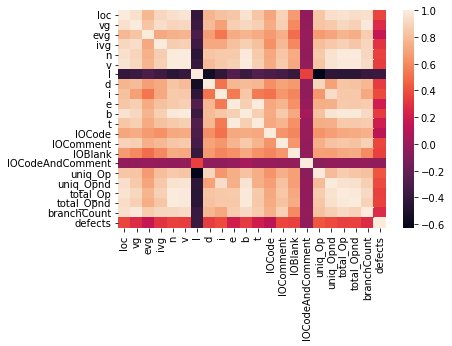

In [67]:
import pandas as pd

from sklearn.metrics import *
data = '/content/data/kc1.csv'
original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val = data_preprocessor(data)
all_data = [original_data, original_X, original_Y,combined_training_data,x_train1,x_train2,x_train,x_test,x_val,y_train1,y_train2,y_train,y_test,y_val]

nn_clf, cnn_clf, svm_clf, rf_clf, xgboost_clf = send_classifiers_to_LR_file()
log_reg_clf, new_val_set_x_matrix = send_results_to_logistic_regression()

prediction = log_reg_clf.predict(new_val_set_x_matrix)
print('Accuracy:',accuracy_score(y_val.values,prediction))